IMPORT the libraries

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import sys
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from torch.utils.data import DataLoader
from geomdl import NURBS
import time
import pickle
import glob
import re
from collections import OrderedDict
import configparser
import torch
import numpy as np
import lpips
from skimage.metrics import structural_similarity as ssim

2024-05-02 03:07:57.287830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 03:07:58.223867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#!python3.10 -m pip install imageio

import imageio

In [3]:
#!python3.10 -m pip install tensorflow
#!python3.10 -m pip install TensorRT

Creating the Dataset for the models

In [3]:
class CustomDataset(Dataset):
    @staticmethod
    def return_test_train(root_dir, test_size=0.1, random_state=22):
        image_data = []  # Use a local variable to collect images
        files = os.listdir(os.path.join(root_dir, "images2"))
        for i in range(len(files)):
            image = np.load(os.path.join(root_dir, "images2", f"signed_distances{i}.npy"), allow_pickle=True)
            image_data.append(image)

            if len(image_data) == 10000:
                print("Loaded 10000 images")
                break
        # this loads all the control points
        data = np.array(image_data)
        control_points = np.load(os.path.join(root_dir, "lhs_ctrlpts.npy"), allow_pickle=True)
        control_points=control_points[:len(data)]
        train_data_cp, test_data_cp, train_data_sdf, test_data_sdf = train_test_split(
            control_points, data, test_size=test_size, random_state=random_state
        )
        # Convert NumPy arrays to PyTorch tensors
        return (
            torch.tensor(train_data_cp, dtype=torch.float32),
            torch.tensor(test_data_cp, dtype=torch.float32),
            torch.tensor(train_data_sdf, dtype=torch.float32),
            torch.tensor(test_data_sdf, dtype=torch.float32),
        )

    def __init__(self, control_points, signed_distance_functions, perturb_control_points, device='cpu'):
        self.device = device  # Generally keep it 'cpu' unless specifically needed
        if perturb_control_points:
            self.control_points, self.signed_distance_functions = self.increase_data(
                control_points, signed_distance_functions
            )
        else:
            self.control_points = control_points
            self.signed_distance_functions = signed_distance_functions

    def __len__(self):
        return len(self.control_points)

    def __getitem__(self, idx):
        control_point = self.control_points[idx]
        sdf = self.signed_distance_functions[idx]
        return {"control_point": control_point.to(self.device), "signed_distance_function": sdf.to(self.device)}

    def increase_data(self, control_points, sdf, perturbation_factor=0.001, num_times=5):
        augmented_control_points = control_points.clone()
        augmented_sdf = sdf.clone()
        for _ in range(num_times):
            noise = torch.rand_like(control_points) * 2 * perturbation_factor - perturbation_factor
            perturbed_control_points = control_points + noise
            perturbed_sdf = sdf  # Assuming no change to sdf, adjust if necessary
            augmented_control_points = torch.cat((augmented_control_points, perturbed_control_points), dim=0)
            augmented_sdf = torch.cat((augmented_sdf, perturbed_sdf), dim=0)
        return augmented_control_points, augmented_sdf

#train_dataset = CustomDataset(train_data_cp, train_data_sdf, True, device='cpu')
#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

To create sdf

In [4]:

# function to compute signed distance from a point to a convex polygon
def signed_distance_polygon(point, polygon_vertices):
    """
    Calculate the signed distance from a point to a convex polygon.

    Parameters:
    - point: NumPy array of shape (2,) representing the point
    - polygon_vertices: NumPy array of shape (num_vertices, 2) representing the vertices of the convex polygon

    Returns:
    - Signed distance from the point to the polygon
    """
    num_vertices = polygon_vertices.shape[0]

    # Initialize variables
    d = np.inf
    s = 1.0

    for i in range(num_vertices):
        j = (i - 1) % num_vertices
        e = polygon_vertices[j] - polygon_vertices[i]
        w = point - polygon_vertices[i]

        # Calculate the perpendicular distance
        b = w - e * np.clip(np.dot(w, e) / np.dot(e, e), 0.0, 1.0)
        d = min(d, np.linalg.norm(b))

        # Determine the sign based on winding number
        if (polygon_vertices[i, 1] <= point[1] < polygon_vertices[j, 1]) or (polygon_vertices[j, 1] <= point[1] < polygon_vertices[i, 1]):
            if polygon_vertices[i, 1] <= point[1] < polygon_vertices[j, 1]:
                if e[0] * w[1] > e[1] * w[0]:
                    s = -s
            elif polygon_vertices[j, 1] <= point[1] < polygon_vertices[i, 1]:
                if e[0] * w[1] < e[1] * w[0]:
                    s = -s

    return s * d

def curve_point_nurbs(control_pts=[[-0.7, 0.7, 0], [0, 0.7, 0], [0.7, 0.7, 0], [0.7, 0, 0], [0.7, -0.7, 0], [-0.7, 0, 0],[-0.7,-0.7,0],[-0.7,0,0],[-0.7, 0.7, 0]],knotvec= [0, 0,0,0.14285714,0.28571429,0.42857143,0.57142857,0.71428571,0.85714286,1, 1, 1],
                delta=0.007):
    # Create a 3-dimensional B-spline Curve
    curve = NURBS.Curve()

    # Set degree
    curve.degree = 2

    # Set control points (weights vector will be 1 by default)
    # Use curve.ctrlptsw is if you are using homogeneous points as Pw
    # let's vary each point in 1000 * 8
    # 6 CP
    # curve.ctrlpts =[[-0.7, 0.7, 0], [0, 0.7, 0], [0.7, 0.7, 0], [0.7, 0, 0], [0.7, -0.7, 0], [-0.7, 0, 0],[-0.7,-0.7,0],[-0.7,0,0],[-0.7, 0.7, 0]]
    curve.ctrlpts=control_pts
    # 9th control point is same as first control point 
    # let's vary the radius between 0.01 and 0.7 in magnitude and angle theta about -10 to 10 degrees and produce 
    # 60000 samples 
    # Set knot vector
    # this is fixed
    curve.knotvector = knotvec
    # setting this value such that it is not small
    # Set evaluation delta (controls the number of curve points)
    curve.delta = delta

    # Get curve points (the curve will be automatically evaluated)
    return curve.evalpts

In [5]:
torch.cuda.empty_cache()

This block of code is to test if the loader works and the curve points have been correctly matched to the sdf

Loaded 10000 images
torch.Size([9000, 9, 2])
54000
(9, 2)
(9, 2)


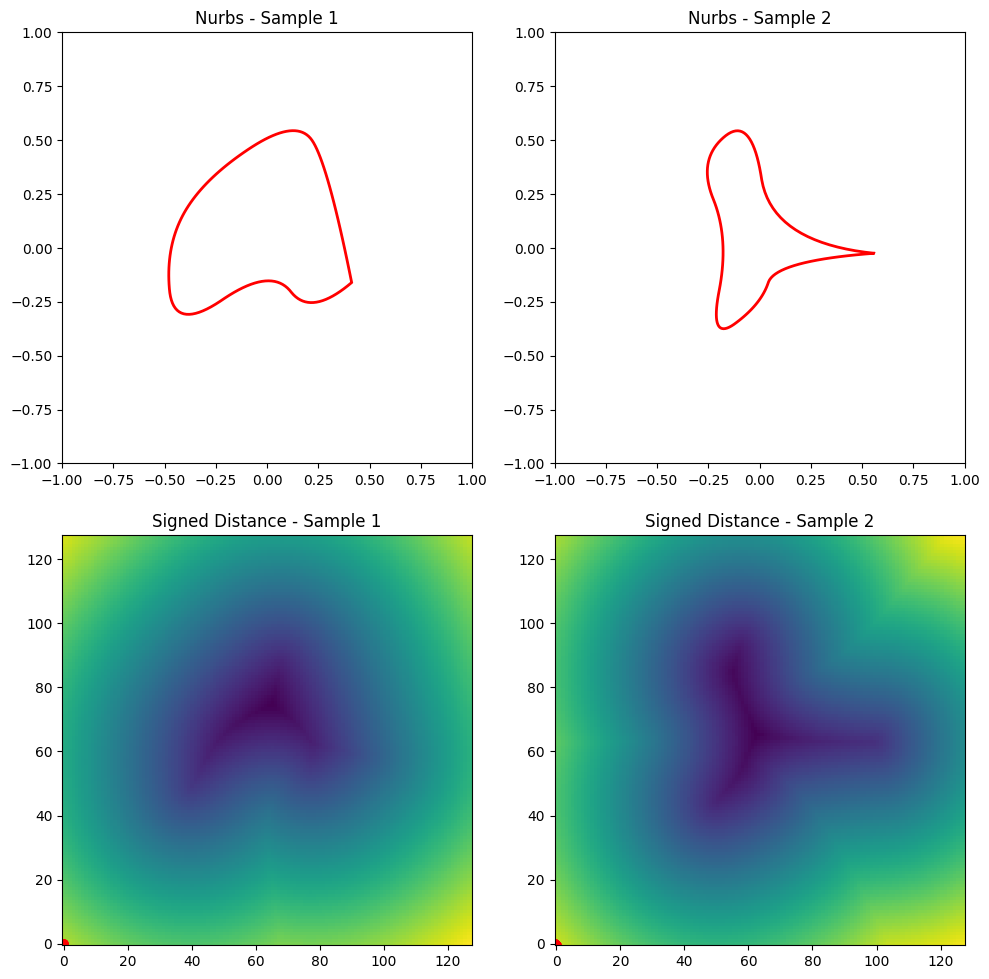

In [6]:

# # Example usage:
root_dir = 'Downloads/'
train_data_cp, test_data_cp, train_data_sdf, test_data_sdf = CustomDataset.return_test_train(root_dir)

# Create a CustomDataset instance
print(train_data_cp.shape)
custom_dataset = CustomDataset(train_data_cp, train_data_sdf, perturb_control_points=True)
# number of data points here 
print(len(custom_dataset))
# exit()
# Create DataLoader for training set
batch_size = 2
train_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)
# print(len(train_loader))
# exit()
batch_iterator = iter(train_loader)
batch = next(batch_iterator)
# Extract input and output data from the batch
x_data_np = batch['control_point'].numpy()
y_data_np = batch['signed_distance_function'].numpy()

# Create a figure with subplots for each sample in the batch
fig, axs = plt.subplots(2,len(x_data_np), figsize=(10, 5 * len(x_data_np)))

for i in range(len(x_data_np)):
    # Extract control points and reshape signed distance function
    x_data_i = x_data_np[i]
    print(x_data_i.shape)
    y_data_i = y_data_np[i]
    # Generate grid points
    x = np.linspace(-1, 1, 128)
    y = np.linspace(-1, 1, 128)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.column_stack((xx.flatten(), yy.flatten()))

    # Generate polygon
    polygon = curve_point_nurbs(x_data_i)

    # Plot the polygon
    axs[0, i].add_patch(Polygon(polygon, edgecolor='red', fill=None, linewidth=2))
    axs[0, i].set_xlim(-1, 1)
    axs[0, i].set_ylim(-1, 1)
    axs[0, i].set_title(f'Nurbs - Sample {i+1}')

    # Plot the image
    img_true = axs[1, i].imshow(y_data_i,origin='lower')
    # img = axs[i, 1].imshow(y_data_i, cmap='viridis', extent=(-1, 1, -1, 1))
    axs[1, i].set_title(f'Signed Distance - Sample {i+1}')

    # Highlight points with signed distances between -0.003 and 0.003
    chk = y_data_i.flatten()
    x = (chk > -0.003) & (chk < 0.003)
    highlighted_points = grid_points[x]
    axs[1, i].scatter(highlighted_points[:, 0], highlighted_points[:, 1], c='red', marker='.', label='Points in [-0.003, 0.003]')

    # # Add colorbar
    # cbar = fig.colorbar(img, ax=axs[i, 1], orientation='vertical')

# Show the plot
plt.tight_layout()
plt.savefig('batch_visualization.png')

DEFINE THE MODEL

In [7]:
class VAEEncoder(nn.Module):
    def __init__(self, input_size, hidden_layer_size=[16,14,12], latent_dim=16):
        super(VAEEncoder, self).__init__()

        # Encoder
        self.encoder_layers = nn.ModuleList()
        flat_input_size = input_size[0] * input_size[1]
        current_input_size = flat_input_size

        for hidden_size in hidden_layer_size:
            self.encoder_layers.append(nn.Linear(current_input_size, hidden_size))
            self.encoder_layers.append(nn.ReLU())
            current_input_size = hidden_size

        # Outputs for mu and log_var
        self.fc_mu = nn.Linear(current_input_size, latent_dim)
        self.fc_log_var = nn.Linear(current_input_size, latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)  # 'randn_like' ensures that the random numbers are of the same type and device as std
        return mu + eps * std  # Return the reparameterized samples

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, output_size):
        super(VAEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Adjust output to match the range of signed distance field values
            
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)  # Reshape for the convolutional layers
        return self.decoder(z)

class VAE(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes=[16,14,12], latent_dim=16, output_size=128):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_size, hidden_layer_sizes, latent_dim)
        self.decoder = VAEDecoder(latent_dim, output_size)

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var

Loading the configuration file from the folder : Downloads/ : update the config file for each run of test/train 

In [12]:

def parse_config(config_file):
    # Initialize the configparser
    print(f'Parsing config file: {config_file}')
    config = configparser.ConfigParser()

    # Read the configuration file
    config.read(config_file)

    # Extract parameters
    mode = config.get('Settings','mode')  # 'train' or 'test'
    batch_size = config.getint('Settings','batch_size')
    learning_rate = config.getfloat('Settings','learning_rate')
    epochs = config.getint('Settings','epochs')
    root_directory = config.get( 'Settings','root_directory')
    save_path = config.get('Settings','save_path')

    return mode, batch_size, learning_rate, epochs, root_directory, save_path

Function that performs the training. (This is called in the main code )

In [8]:
def train(train_loader, model, optimizer, criterion, device, num_epochs, save_path, test_loader):
    model.to(device)
    model.train()

    # Gradient accumulation steps
    accumulation_steps = 4  # Define how many steps to accumulate gradients for

    if os.path.exists(os.path.join(save_path, "train_model_epoch.pkl")):
        print("Resuming training from previous checkpoint")
        model, optimizer, start_epoch, loss_per_epoch, best_val_loss, val_loss_per_epoch = load_model(model, optimizer, save_path)
        model.to(device)  # Ensure model is on the correct device
        print(f"Starting from epoch {start_epoch}")
    else:
        start_epoch = 0
        loss_per_epoch = []
        val_loss_per_epoch = []
        best_val_loss = float('inf')

    for i in range(start_epoch, num_epochs):
        model.train()  # Reinforce training mode
        train_loss = 0
        optimizer.zero_grad()  # Zero the gradients at the start of each epoch
        
        for batch_idx, batch in enumerate(train_loader):
            control_points = batch['control_point'].to(device)
            signed_distance_functions = batch['signed_distance_function'].to(device)
            output = model(control_points)
            output = output.squeeze(1)  # Ensure output shape matches the target shape
            loss = criterion(output, signed_distance_functions)
            loss = loss / accumulation_steps  # Normalize loss to account for accumulation
            loss.backward()
            train_loss += loss.item() * accumulation_steps  # Reverse normalization for actual loss tracking

            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()  # Clear gradients after updating weights
            del output
            del control_points
            del signed_distance_functions

        train_loss /= len(train_loader.dataset)
        loss_per_epoch.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for test_batch in test_loader:
                test_cp, test_sdf = test_batch['control_point'].to(device), test_batch['signed_distance_function'].to(device)
                test_output = model(test_cp).squeeze(1)
                val_loss += criterion(test_output, test_sdf).item()
                del test_cp,test_sdf

        val_loss /= len(test_loader)  # Average the validation loss
        val_loss_per_epoch.append(val_loss)

        print(f"Epoch {i+1}: Train Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")
        
        if val_loss < best_val_loss and i > 2:
            best_val_loss = val_loss
            save_model(model, optimizer, loss_per_epoch,val_loss_per_epoch,i, best_val_loss, save_path)
            torch.cuda.empty_cache()
        
        if (i + 1) % 100 == 0:
            save_model_epoch(model, i + 1, save_path)
        
        if i % 100 == 0 and i != 0:
            plt.figure()
            plt.plot(loss_per_epoch, label='Train Loss')
            plt.plot(val_loss_per_epoch, label='Validation Loss')
            plt.title('Loss vs Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(os.path.join(save_path, f"loss_plot_epoch_{i}.png"))
            plt.close()

    return train_loss

Function Saving the created model and loading the existing model : change the path and model name to avoid overwriting the folders

In [9]:

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def save_model(model, optimizer, loss_per_epoch, epoch,best_val_loss,val_loss_per_epoch, save_path):
    checkpoint_data = {
        'epoch': epoch,
        'loss_per_epoch': loss_per_epoch,
        'best_val_loss': best_val_loss,
        'val_loss_per_epoch': val_loss_per_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    checkpoint_path = os.path.join(save_path, f"CStrain_model_epoch.pkl")
    with open(checkpoint_path, 'wb') as checkpoint_file:
        pickle.dump(checkpoint_data, checkpoint_file)
def save_model_epoch(model, epoch,save_path):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    path=create_directory(os.path.join(save_path, "CSmodels"))
    checkpoint_path = os.path.join(path, f"model_epoch{epoch}.pkl")
    with open(checkpoint_path, 'wb') as checkpoint_file:
        pickle.dump(checkpoint_data, checkpoint_file)
def load_model(model, optimizer, save_path,):
    checkpoint_path = os.path.join(save_path, "CStrain_model_epoch.pkl")
    with open(checkpoint_path, 'rb') as checkpoint_file:
        checkpoint_data = pickle.load(checkpoint_file)
    model.load_state_dict(checkpoint_data['model_state_dict'])
    optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
    epoch = checkpoint_data['epoch']+1
    best_val_loss = checkpoint_data['best_val_loss']
    val_loss_per_epoch = checkpoint_data['val_loss_per_epoch']
    loss_per_epoch = checkpoint_data['loss_per_epoch']
    return model, optimizer, epoch, loss_per_epoch, best_val_loss, val_loss_per_epoch
import glob
import re

def load_model_epoch(model, save_path):
    # List all model files and find the one with the highest epoch number
    model_files = glob.glob(os.path.join(save_path, "CSmodels/model_epoch*.pkl"))
    latest_model_file = max(model_files, key=lambda x: int(re.findall(r'\d+', x)[-1]))

    with open(latest_model_file, 'rb') as checkpoint_file:
        checkpoint_data = pickle.load(checkpoint_file)

    # Create a new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in checkpoint_data['model_state_dict'].items():
        name = k[7:] if k.startswith('module.') else k  # remove `module.`
        new_state_dict[name] = v

    # Load the weights into the model
    model.load_state_dict(new_state_dict)
    return model



For the VAE

In [10]:
print("Control Points Shape:", train_data_cp.shape)
print("Control Points Data Type:", train_data_cp.dtype)
print("SDF Shape:", train_data_sdf.shape)
print("SDF Data Type:", train_data_sdf.dtype)
print("Max, Min of SDF:", train_data_sdf.max().item(), train_data_sdf.min().item())

Control Points Shape: torch.Size([9000, 9, 2])
Control Points Data Type: torch.float32
SDF Shape: torch.Size([9000, 128, 128])
SDF Data Type: torch.float32
Max, Min of SDF: 1.3942300081253052 -0.4765886962413788


In [13]:
import torch.optim as optim

def to_numpy(tensor):
    return tensor.cpu().detach().numpy() if tensor.requires_grad else tensor.cpu().numpy()
# the file is in experiments/splinetofield/executor/train.py


def train_func(batch_size, num_epochs, train_data_cp, train_data_sdf, test_loader, save_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Initialize the VAE instead of EncoderDecoder
    model = VAE(train_data_cp[0].shape, hidden_layer_sizes=[16,14,12], latent_dim=16, output_size=128).to(device)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_data_sdf = 2 * ((train_data_sdf - train_data_sdf.min()) / (train_data_sdf.max() - train_data_sdf.min())) - 1

    # Define the VAE loss components: Reconstruction loss and KL divergence
    def vae_loss(recon_x, x, mu, log_var):
        # Calculate the binary cross-entropy loss
        MSE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
        #print(f'MSE', MSE)
        # KL divergence
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        #print(f'KLD', KLD)
        return MSE + KLD

    #train_data_sdf = (train_data_sdf - train_data_sdf.min()) / (train_data_sdf.max() - train_data_sdf.min())

    custom_dataset = CustomDataset(train_data_cp, train_data_sdf, True)
    train_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            control_points, signed_distance_functions = batch['control_point'].to(device), batch['signed_distance_function'].to(device)
            signed_distance_functions = signed_distance_functions.unsqueeze(1)

            optimizer.zero_grad()
            # Model will return reconstruction, mu, and log_var
            recon_batch, mu, log_var = model(control_points)
            if isinstance(model, nn.DataParallel):
                mu = mu.contiguous().view(-1, mu.shape[-1])
                log_var = log_var.contiguous().view(-1, log_var.shape[-1])

            loss = vae_loss(recon_batch, signed_distance_functions, mu, log_var)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss per epoch
        print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader)}')

def test_func(test_data_cp,test_data_sdf,save_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Testing the model")

    # Initialize VAE model (Make sure to adjust the architecture parameters as needed)
    model = VAE(test_data_cp[0].shape, hidden_layer_sizes=[16,14,12], latent_dim=16, output_size=128).to(device)

    # Load the trained model
    model = load_model_epoch(model, save_path)
    model.eval()
    model.to(device)

    test_loader = DataLoader(dataset=CustomDataset(test_data_cp, test_data_sdf, False), batch_size=1, shuffle=False)

    total_loss = 0
    mse_loss = nn.MSELoss()
    for batch in test_loader:
        test_cp, test_sdf = batch['control_point'].to(device), batch['signed_distance_function'].to(device)
        test_sdf = test_sdf.unsqueeze(1)  # Ensure the dimension matches if needed
        recon_sdf, mu, log_var = model(test_cp)
        
        # Calculate VAE loss
        recon_loss = mse_loss(recon_sdf, test_sdf)
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        total_loss += recon_loss.item() + kld.item()

    average_loss = total_loss / len(test_loader)
    print(f"Test Loss: {average_loss:.4f}")
    
    # calculate lpips
    lpips = calculate_lpips(computed_sdf,test_data_sdf)
    # compute the mean lpips
    print(f"Mean lpips is {lpips}")
    # calculate ssim

    # calculate psnr
    np_computed_sdf = to_numpy(computed_sdf)
    np_test_data_sdf = to_numpy(test_data_sdf)
    psnr = calculate_psnr(np_computed_sdf,np_test_data_sdf)
    print(f"Mean psnr is {psnr}")
    # function to convert torch tensor to NumPy array
    ssim = calculate_ssim(np_computed_sdf,np_test_data_sdf)
    # compute the mean ssim
    print(f"Mean ssim is {ssim}")
    # Select 10 test samples
    selected_indices = [0, 1, 2, 3]
    selected_test_data_cp = test_data_cp[selected_indices]
    selected_test_data_sdf = test_data_sdf[selected_indices]

    # Evaluate on selected test data
    computed_sdf = model(selected_test_data_cp.to(device))
    computed_sdf_np = to_numpy(computed_sdf)

    fig, axs = plt.subplots(len(selected_indices), 3, figsize=(15, 5 * len(selected_indices)))
    
    for i in range(len(selected_indices)):
        # Extract control points and reshape signed distance function
        x_data_i = to_numpy(selected_test_data_cp[i])
        y_data_i_true = to_numpy(selected_test_data_sdf[i])
        y_data_i_pred = computed_sdf_np[i]

        # Generate polygon
        polygon = curve_point_nurbs(x_data_i)

        # Plot the polygon
        axs[i, 0].add_patch(Polygon(polygon, edgecolor='red', fill=None, linewidth=2))
        axs[i, 0].set_xlim(-1, 1)
        axs[i, 0].set_ylim(-1, 1)
        axs[i, 0].set_title(f'Nurbs - Sample {selected_indices[i]}')

        # Plot the true signed distance field
        img_true = axs[i, 1].imshow(y_data_i_true,origin='lower')
        axs[i, 1].set_title(f'True Signed Distance - Sample {selected_indices[i]}')

        # Plot the predicted signed distance field
        img_pred = axs[i, 2].imshow(y_data_i_pred[0], origin='lower')
        axs[i, 2].set_title(f'Predicted Signed Distance - Sample {selected_indices[i]}')

    # Show the plot
    plt.tight_layout()
    plt.savefig('full_visualization.png')
    plt.show()
    # plot the results


if __name__ == '__main__':
    config_file_path = 'Downloads/config1.txt'
    print(config_file_path)
    mode, batch_size, learning_rate, epochs, root_directory, save_path = parse_config(config_file_path)
    train_data_cp, test_data_cp, train_data_sdf, test_data_sdf = CustomDataset.return_test_train(root_directory)
    print("train_data_cp done")
    small_batch_size = 2
    test_dataset = CustomDataset(test_data_cp, test_data_sdf, False)  # Assuming False means no data augmentation
    print("test_dataset done")
    test_loader = DataLoader(dataset=test_dataset, batch_size=small_batch_size, shuffle=False) 
    print("test_loader done")
    if mode == 'train':
        print("entering train done")
        # (batch_size,num_epochs,train_data_cp,train_data_sdf,test_data_cp,test_data_sdf,save_path)
        train_func(batch_size,epochs, train_data_cp, train_data_sdf,test_loader ,"Downloads/")
        print("train done")
    elif mode == 'test':
        print("entering test done")
        test_func(test_data_cp,test_data_sdf,save_path)
        print("test done")
    else:
        print("Mode not supported")


Downloads/config1.txt
Parsing config file: Downloads/config1.txt
Loaded 10000 images
train_data_cp done
test_dataset done
test_loader done
entering train done


/home/exouser/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Average Loss: 67418.04368844416
Epoch 2, Average Loss: 16999.457373741112
Epoch 3, Average Loss: 13112.55085183094
Epoch 4, Average Loss: 12098.521211307761
Epoch 5, Average Loss: 10070.371349461271
Epoch 6, Average Loss: 8380.315798212567
Epoch 7, Average Loss: 6680.853060320091
Epoch 8, Average Loss: 6562.712874426096
Epoch 9, Average Loss: 6508.66141108653
Epoch 10, Average Loss: 6473.699563555243
Epoch 11, Average Loss: 6443.858431413841
Epoch 12, Average Loss: 6281.26197156861
Epoch 13, Average Loss: 5494.516760948145
Epoch 14, Average Loss: 4306.13940313981
Epoch 15, Average Loss: 4226.210386447997
Epoch 16, Average Loss: 4169.913093169153
Epoch 17, Average Loss: 4121.708689034268
Epoch 18, Average Loss: 4100.094086416525
Epoch 19, Average Loss: 4081.736485196516
Epoch 20, Average Loss: 4056.8901118418617
Epoch 21, Average Loss: 4050.404514981672
Epoch 22, Average Loss: 4026.0686541372
Epoch 23, Average Loss: 4004.5477329633813
Epoch 24, Average Loss: 3981.809587957735
E

From here , models with varying parameters have been created. Once the mnodel and its parameters are trained , i have renamed them into models-v2,models-v3 and models-v3 manually. instead of changing the code

for testing the data 

This is for testing the data , change the parameter in config file and change the name of the folder to the folder you have saved your model in : load_model_epoch function

function to evaluate the data 

In [50]:
def calculate_psnr(reference_img, predicted_img,device):
    mse = np.mean((reference_img - predicted_img) ** 2)
    max_pixel_value = np.max(reference_img)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr
def calculate_lpips(reference_img, predicted_img,device ,loss_fn):
    # If the images have only one channel, duplicate it to get 3 channels
    predicted_img = predicted_img.unsqueeze(1)
    #print(reference_img.shape)
    #print(predicted_img.shape)
    if reference_img.shape[1] == 1:
        reference_img = reference_img.repeat(1, 3, 1, 1)
    if predicted_img.shape[1] == 1:
        predicted_img = predicted_img.repeat(1, 3, 1, 1) 
    return loss_fn(reference_img, predicted_img).mean()

def calculate_ssim(reference_img, predicted_img):
    predicted_img = np.expand_dims(predicted_img, axis=1)
    print(reference_img.shape)
    print(predicted_img.shape)

    # Calculate the data range
    data_range = reference_img.max() - reference_img.min()

    return np.mean(ssim(reference_img[:,0], predicted_img[:,0], data_range=data_range, multichannel=False))


In [ ]:
def return_test_only(root_dir):
        # return 2000 images and control points after 10000 for testing
        image_data = []  # Use a local variable to collect images
        # files = os.listdir(os.path.join(root_dir, "images2"))
        for i in range(10000, 12000):
            image = np.load(os.path.join(root_dir, "images2", f"signed_distances{i}.npy"), allow_pickle=True)
            image_data.append(image)
        control_points = np.load(os.path.join(root_dir, "lhs_ctrlpts.npy"), allow_pickle=True)
        control_points=control_points[10000:12000]
        # Convert NumPy arrays to PyTorch tensors
        image_data = np.array(image_data)
        return (
            torch.tensor(control_points, dtype=torch.float32),
            torch.tensor(image_data, dtype=torch.float32),
 


In [ ]:
for i in range(len(selected_indices)):
 
 
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        # plot the true curve
 
        # use the above code to plot the true curve
        x_data_i = test_data_cp_np[selected_indices[i]]
        # Generate polygon
        polygon = curve_point_nurbs(x_data_i)
        # Plot the polygon
        axs[2].add_patch(Polygon(polygon, edgecolor='red', fill=None, linewidth=2))
        axs[2].set_xlim(-1, 1)
        axs[2].set_ylim(-1, 1)
        axs[2].set_title(f'Nurbs - Sample {selected_indices[i]}')
 
        # plot the predicted curve
        x_data_i = ctrl_pts_np[selected_indices[i]] 
        # Generate polygon
        polygon = curve_point_nurbs(x_data_i)
 
        # Plot the polygon
        axs[1].add_patch(Polygon(polygon, edgecolor='red', fill=None, linewidth=2))
        axs[1].set_xlim(-1, 1)
        axs[1].set_ylim(-1, 1)
        axs[1].set_title(f'Predicted Nurbs - Sample {selected_indices[i]}')
 
 
        # plot the true signed distance field
        y_data_i_true = to_numpy(test_data_sdf[selected_indices[i]])
        # print(y_data_i_true.shape)
        img_true = axs[0].imshow(y_data_i_true,origin='lower')
        axs[0].set_title(f'Input True Signed Distance - Sample {selected_indices[i]}')
 
        # plot the predicted signed distance field
 
        y_data_i_pred = to_numpy(computed_sdf[i][0])
        print(y_data_i_pred.shape)
        img_pred = axs[3].imshow(y_data_i_pred, origin='lower')
        axs[3].set_title(f'Predicted Signed Distance - Sample {selected_indices[i]}')
 
        plt.tight_layout()  
        plt.savefig(f'me592_experiments/test_visualization_both{i}.png')
        image_data.append(f'me592_experiments/test_visualization_both{i}.png')
        plt.close()
    # filenames = [f'test_results_visualization_{i}.png' for i in range(len(selected_indices))]
    # # Convert the images into a GIF
    images = [imageio.v2.imread(filename) for filename in image_data]
    imageio.mimsave('me592_experiments/test_visualization._full_model.gif', images, duration=50)  # Adjust fps (frames per second) as needed
 
    # load

with visualisation

In [22]:

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def save_model(model, optimizer, loss_per_epoch, epoch,best_val_loss,val_loss_per_epoch, save_path):
    checkpoint_data = {
        'epoch': epoch,
        'loss_per_epoch': loss_per_epoch,
        'best_val_loss': best_val_loss,
        'val_loss_per_epoch': val_loss_per_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    checkpoint_path = os.path.join(save_path, f"train_model_epoch.pkl")
    with open(checkpoint_path, 'wb') as checkpoint_file:
        pickle.dump(checkpoint_data, checkpoint_file)
def save_model_epoch(model, epoch,save_path):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    path=create_directory(os.path.join(save_path, "models"))
    checkpoint_path = os.path.join(path, f"model_epoch{epoch}.pkl")
    with open(checkpoint_path, 'wb') as checkpoint_file:
        pickle.dump(checkpoint_data, checkpoint_file)
def load_model(model, optimizer, save_path,):
    checkpoint_path = os.path.join(save_path, "train_model_epoch.pkl")
    with open(checkpoint_path, 'rb') as checkpoint_file:
        checkpoint_data = pickle.load(checkpoint_file)
    model.load_state_dict(checkpoint_data['model_state_dict'])
    optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
    epoch = checkpoint_data['epoch']+1
    best_val_loss = checkpoint_data['best_val_loss']
    val_loss_per_epoch = checkpoint_data['val_loss_per_epoch']
    loss_per_epoch = checkpoint_data['loss_per_epoch']
    return model, optimizer, epoch, loss_per_epoch, best_val_loss, val_loss_per_epoch
import glob
import re

def load_model_epoch(model, save_path):
    # List all model files and find the one with the highest epoch number
    model_files = glob.glob(os.path.join(save_path, "models-v4/model_epoch*.pkl"))
    latest_model_file = max(model_files, key=lambda x: int(re.findall(r'\d+', x)[-1]))

    with open(latest_model_file, 'rb') as checkpoint_file:
        checkpoint_data = pickle.load(checkpoint_file)

    # Create a new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in checkpoint_data['model_state_dict'].items():
        name = k[7:] if k.startswith('module.') else k  # remove `module.`
        new_state_dict[name] = v

    # Load the weights into the model
    model.load_state_dict(new_state_dict)
    return model



In [21]:
def return_test_only(root_dir):
        # return 2000 images and control points after 10000 for testing
        image_data = []  # Use a local variable to collect images
        # files = os.listdir(os.path.join(root_dir, "images2"))
        for i in range(10000, 12000):
            image = np.load(os.path.join(root_dir, "images2", f"signed_distances{i}.npy"), allow_pickle=True)
            image_data.append(image)
        control_points = np.load(os.path.join(root_dir, "lhs_ctrlpts.npy"), allow_pickle=True)
        control_points=control_points[10000:12000]
        # Convert NumPy arrays to PyTorch tensors
        image_data = np.array(image_data)
        
        return (
            torch.tensor(control_points, dtype=torch.float32),
            torch.tensor(image_data, dtype=torch.float32),
        )

Downloads/config1.txt
Parsing config file: Downloads/config1.txt
Loaded 10000 images
torch.Size([2000, 9, 2]) here
Testing the model
torch.Size([2000, 9, 2])
EncoderDecoder(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=14, bias=True)
    (3): ReLU()
    (4): Linear(in_features=14, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=16, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 64, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7

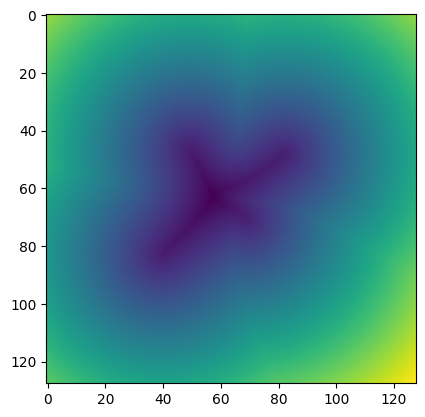

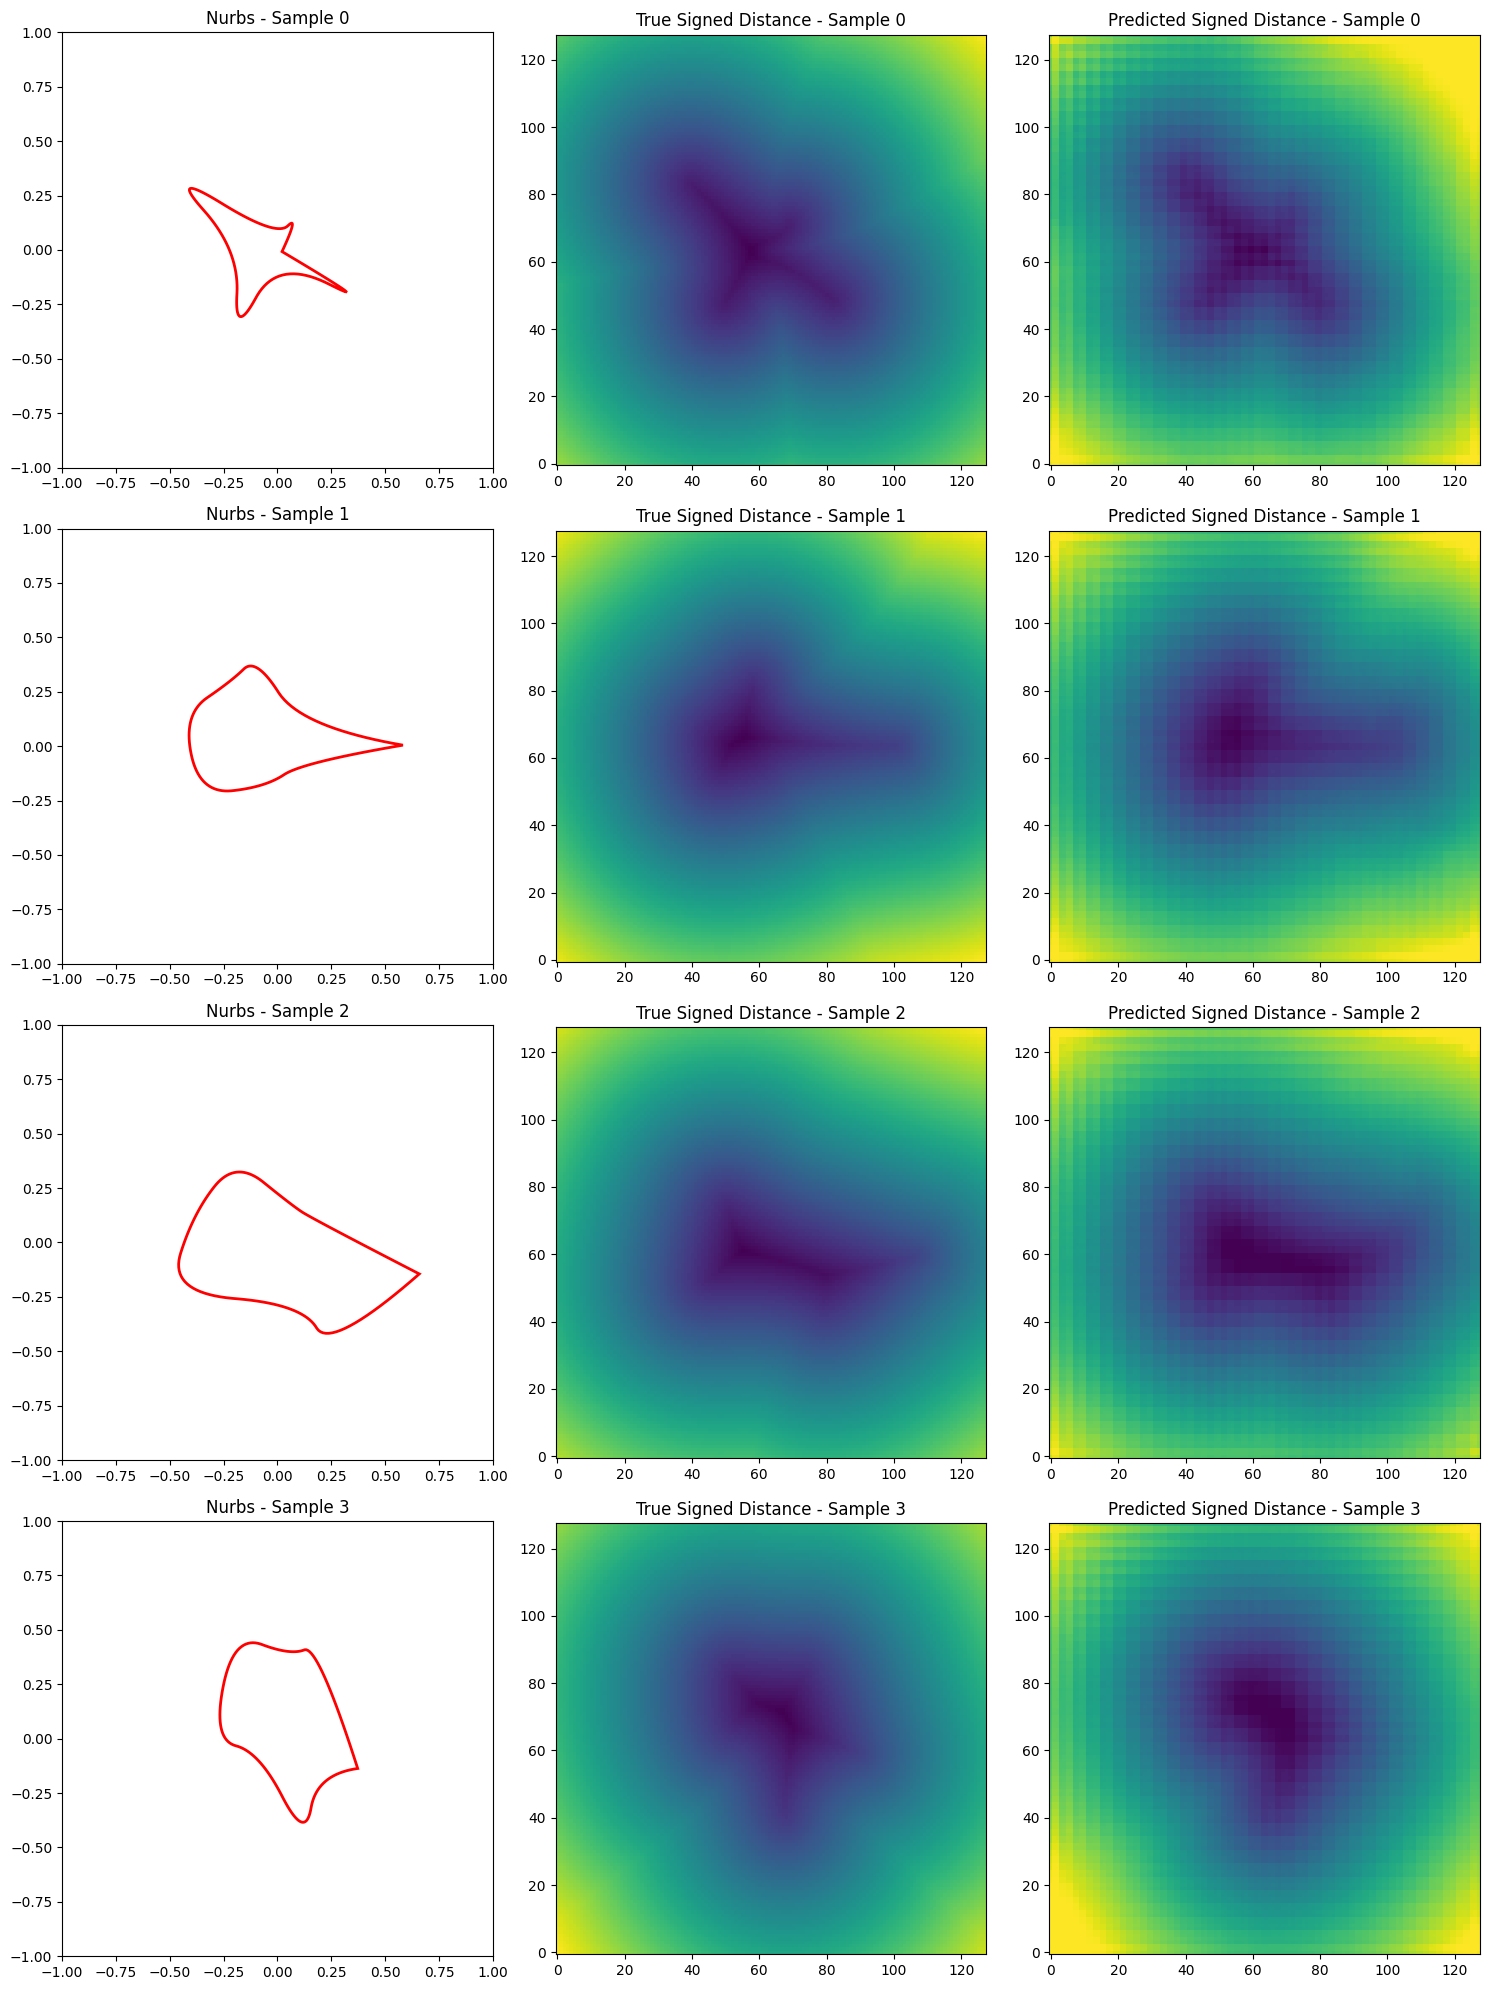

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/exouser/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
(2, 1, 128, 128)
(2, 1, 128, 128)


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [53]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy() if tensor.requires_grad else tensor.cpu().numpy()

#test_func(test_data_cp,test_data_sdf,test_loader,save_path)
def test_func(test_data_cp,test_data_sdf,test_loader,save_path):
    print("Testing the model")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = EncoderDecoder(test_data_cp[0].shape, hidden_layer_size=[16,14,12], latent_dim=16,output_size=128).to(device)
    print(test_data_cp.shape)
    # Load the model
    model = load_model_epoch(model, save_path)
    model.eval()
    model.to(device)
    print(model)
    # selected_indices = [0, 1, 2, 3]
    # test_data_cp = test_data_cp.to(device)
    # selected_test_data_cp = test_data_cp[selected_indices]
    # selected_test_data_sdf = test_data_sdf[selected_indices]
    selected_indices = [0, 1, 2, 3]
    test_data_cp = test_data_cp.to(device)
    selected_test_data_cp = test_data_cp[selected_indices]
    selected_test_data_sdf = test_data_sdf[selected_indices]

    # Evaluate on selected test data
    computed_sdf = model(selected_test_data_cp.to(device))
    computed_sdf_np = to_numpy(computed_sdf)
    fig, axs = plt.subplots(len(selected_indices), 3, figsize=(15, 5 * len(selected_indices)))
    
    for i in range(len(selected_indices)):
        #fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        # Extract control points and reshape signed distance function
        x_data_i = to_numpy(selected_test_data_cp[i])
        y_data_i_true = to_numpy(selected_test_data_sdf[i])
        y_data_i_pred = computed_sdf_np[i]

        # Generate polygon
        polygon = curve_point_nurbs(x_data_i)

        # Plot the polygon
        axs[i, 0].add_patch(Polygon(polygon, edgecolor='red', fill=None, linewidth=2))
        axs[i, 0].set_xlim(-1, 1)
        axs[i, 0].set_ylim(-1, 1)
        axs[i, 0].set_title(f'Nurbs - Sample {selected_indices[i]}')

        # Plot the true signed distance field
        img_true = axs[i, 1].imshow(y_data_i_true,origin='lower')
        axs[i, 1].set_title(f'True Signed Distance - Sample {selected_indices[i]}')

        # Plot the predicted signed distance field
        img_pred = axs[i, 2].imshow(y_data_i_pred[0], origin='lower')
        axs[i, 2].set_title(f'Predicted Signed Distance - Sample {selected_indices[i]}')

    # Show the plot
    plt.tight_layout()
    plt.savefig('full_visualization_new.png')
    plt.show()
    
    loss_fn_MSE = torch.nn.MSELoss().to(device) 
    losses = []
    lpips_vals = []
    psnr_vals = []
    ssim_vals = []
    loss_fn_LP = lpips.LPIPS(net='alex')
    loss_fn_LP = loss_fn_LP.to(device)
    for batch_idx, batch in enumerate(test_loader):
        test_data_cp = batch['control_point'].to(device)
        test_data_sdf = batch['signed_distance_function'].to(device)
        
        # Evaluate on test data
        with torch.no_grad():
            computed_sdf = model(test_data_cp)
            #print(computed_sdf.shape,'here now')
            computed_sdf=computed_sdf.to(device)
            #print(computed_sdf.device)
            loss_val = loss_fn_MSE(computed_sdf, test_data_sdf)
            #print(loss_val.to(device),'here')
            losses.append(loss_val.item())
    
            # Calculate metrics
            #print(test_data_sdf.device)
            lpips_val = calculate_lpips(computed_sdf, test_data_sdf,device,loss_fn_LP).to(device)
            
            lpips_vals.append(lpips_val)

            # Convert to numpy for PSNR and SSIM calculations
            np_computed_sdf = to_numpy(computed_sdf)
            np_test_data_sdf = to_numpy(test_data_sdf)
            
            psnr_val = calculate_psnr(np_computed_sdf, np_test_data_sdf,device)
            psnr_vals.append(psnr_val)

            ssim_val = calculate_ssim(np_computed_sdf, np_test_data_sdf)
            ssim_vals.append(ssim_val)

        # Clean up to save memory
        del test_data_cp, test_data_sdf, computed_sdf
        torch.cuda.empty_cache()

    # Print the average results
    print(f"Average Loss: {sum(losses) / len(losses)}")
    print(f"Average LPIPS: {sum(lpips_vals) / len(lpips_vals)}")
    print(f"Average PSNR: {sum(psnr_vals) / len(psnr_vals)}")
    #print(f"Average SSIM: {sum(ssim_vals) / len(ssim_vals)}")

if __name__ == '__main__':
    config_file_path = 'Downloads/config1.txt'
    print(config_file_path)
    mode, batch_size, learning_rate, epochs, root_directory, save_path = parse_config(config_file_path)
    train_data_cp, test_data_cp, train_data_sdf, test_data_sdf = CustomDataset.return_test_train(root_directory)
    small_batch_size = 2
      # Assuming False means no data augmentation
    test_data_cp_1,test_data_sdf_1= return_test_only(root_directory)
    test_dataset = CustomDataset(test_data_cp_1, test_data_sdf_1, False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=small_batch_size, shuffle=False) 
    if mode == 'train':
        # (batch_size,num_epochs,train_data_cp,train_data_sdf,test_data_cp,test_data_sdf,save_path)
        train_func(batch_size,epochs, train_data_cp_1, train_data_sdf,test_loader ,"Downloads/")
    elif mode == 'test':
        print(test_data_cp_1.shape , 'here')
        plt.imshow(test_data_sdf_1[0].reshape(128,128))

        test_func(test_data_cp_1,test_data_sdf_1,test_loader,save_path)
        
    else:
        print("Mode not supported")


In [ ]:
images = [imageio.v2.imread(filename) for filename in image_data]
imageio.mimsave('p_v/test_visualization._full_model.gif', images, duration=50

In [7]:
# Define the directory where the images are stored
import os
folder_path = 'Downloads/images2'

# Get all entries in the directory
entries = os.listdir(folder_path)

# Filter out directories, count only files
files = [entry for entry in entries if os.path.isfile(os.path.join(folder_path, entry))]

# Print the number of files
print(f"There are {len(files)} files in the directory.")
entries = os.listdir(folder_path)

# Filter out directories, keep only files
files = [entry for entry in entries if os.path.isfile(os.path.join(folder_path, entry))]

# Print the first 10 files
for file in files[:10]:
    print(file)


There are 12001 files in the directory.
signed_distances7497.npy
signed_distances3941.npy
signed_distances10237.npy
signed_distances5350.npy
signed_distances8482.npy
signed_distances423.npy
signed_distances3624.npy
signed_distances4388.npy
signed_distances1122.npy
signed_distances9654.npy
